# DETR Object Detection

In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
%pip install -q datasets transformers accelerate timm
%pip install -q -U albumentations>=1.4.5 torchmetrics pycocotools

/Users/henrikvendelbo/.zshenv:.:1: no such file or directory: /Users/henrikvendelbo/.cargo/env
Note: you may need to restart the kernel to use updated packages.
/Users/henrikvendelbo/.zshenv:.:1: no such file or directory: /Users/henrikvendelbo/.cargo/env
zsh:1: 1.4.5 not found
Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys, os
# if "../../.." not in sys.path:
#     sys.path.append("../../..")
proj = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
if proj not in sys.path:
    sys.path.insert(0, proj)
import dataset.models.dinov2_model as dinov2_model

Using cache found in /Volumes/Projects/Evidently/record-thing/dataset/.cache/torch/hub/facebookresearch_dinov2_main
/Volumes/Projects/Evidently/record-thing/dataset/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Volumes/Projects/Evidently/record-thing/dataset/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Volumes/Projects/Evidently/record-thing/dataset/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
# MODEL_NAME = "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"
MODEL_NAME = "facebook/dino-vits16"
IMAGE_SIZE = 480

Load the CPPE-5 dataset

In [39]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")

if "validation" not in cppe5:
    split = cppe5["train"].train_test_split(0.15, seed=1337)
    cppe5["train"] = split["train"]
    cppe5["validation"] = split["test"]

cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

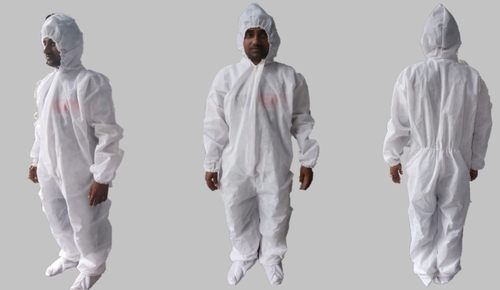

{'image_id': 366,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
 'width': 500,
 'height': 500,
 'objects': {'id': [1932, 1933, 1934],
  'area': [27063, 34200, 32431],
  'bbox': [[29.0, 11.0, 97.0, 279.0],
   [201.0, 1.0, 120.0, 285.0],
   [382.0, 0.0, 113.0, 287.0]],
  'category': [0, 0, 0]}}

In [40]:
display(cppe5["train"][0]["image"])
cppe5["train"][0]

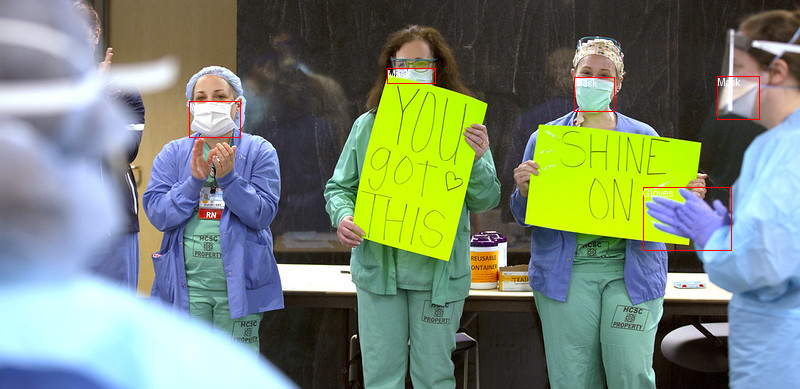

In [41]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][2]["image"]
annotations = cppe5["train"][2]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

#### Preprocess the data



In [42]:
image_mean = [0.485, 0.456, 0.406 ]
image_std = [0.229, 0.224, 0.225]

In [43]:
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

Before passing the images to the image_processor, apply two preprocessing transformations to the dataset:

* Augmenting images
* Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use Albumentations. This library ensures that transformations affect the image and update the bounding boxes accordingly. The 🤗 Datasets library documentation has a detailed guide on how to augment images for object detection, and it uses the exact same dataset as an example. Apply some geometric and color transformations to the image. For additional augmentation options, explore the Albumentations Demo Space.

In [44]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

The image_processor expects the annotations to be in the following format: {'image_id': int, 'annotations': List[Dict]}, where each dictionary is a COCO object annotation. Let’s add a function to reformat annotations for a single example:

In [45]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }

Now you can combine the image and annotation transformations to use on a batch of examples:

In [17]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

Apply this preprocessing function to the entire dataset using 🤗 Datasets with_transform method. This method applies transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor with pixel_values, a tensor with pixel_mask, and labels.

In [46]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

cppe5["train"] = cppe5["train"].with_transform(train_transform_batch)
cppe5["validation"] = cppe5["validation"].with_transform(validation_transform_batch)
cppe5["test"] = cppe5["test"].with_transform(validation_transform_batch)

cppe5["train"][15]



{'pixel_values': tensor([[[-0.3198, -0.3712, -0.4226,  ...,  2.0263,  1.9920,  1.9749],
          [-0.3541, -0.4054, -0.4568,  ...,  2.0434,  2.0263,  2.0092],
          [-0.4054, -0.4397, -0.4911,  ...,  2.0777,  2.0605,  2.0605],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 1.1856,  1.0630,  0.9405,  ...,  2.2010,  2.1660,  2.1485],
          [ 1.1506,  1.0455,  0.9055,  ...,  2.2185,  2.2010,  2.1835],
          [ 1.1155,  1.0105,  0.8704,  ...,  2.2535,  2.2360,  2.2360],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.4614,  0.3916,  0.3219,  ...,  2.4134,  2.3786,  2.3611],
          [ 

In [47]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data


### Preparing function to compute mAP

Object detection models are commonly evaluated with a set of COCO-style metrics. We are going to use torchmetrics to compute mAP (mean average precision) and mAR (mean average recall) metrics and will wrap it to compute_metrics function in order to use in Trainer for evaluation.

Intermediate format of boxes used for training is YOLO (normalized) but we will compute metrics for boxes in Pascal VOC (absolute) format in order to correctly handle box areas. Let’s define a function that converts bounding boxes to Pascal VOC format:

In [48]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

Then, in compute_metrics function we collect predicted and target bounding boxes, scores and labels from evaluation loop results and pass it to the scoring function.

In [49]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

Load the model with AutoModelForObjectDetection using the same checkpoint as in the preprocessing.
Define your training hyperparameters in TrainingArguments.
Pass the training arguments to Trainer along with the model, dataset, image processor, and data collator.
Call train() to finetune your model.
When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the label2id and id2label maps that you created earlier from the dataset’s metadata. Additionally, we specify ignore_mismatched_sizes=True to replace the existing classification head with a new one.



In [50]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the TrainingArguments use output_dir to specify where to save your model, then configure hyperparameters as you see fit. For num_train_epochs=30 training will take about 35 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr_finetuned_cppe5",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=True,
)

In [36]:
!conda list

In [34]:
!conda info --envs

Finally, bring everything together, and call train():

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cppe5["train"],
    eval_dataset=cppe5["validation"],
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

TypeError: Trainer.__init__() got an unexpected keyword argument 'processing_class'

If you have set push_to_hub to True in the training_args, the training checkpoints are pushed to the Hugging Face Hub. Upon training completion, push the final model to the Hub as well by calling the push_to_hub() method.

Copied
trainer.push_to_hub()

## Evaluate

In [25]:
from pprint import pprint

metrics = trainer.evaluate(eval_dataset=cppe5["test"], metric_key_prefix="test")
pprint(metrics)

NameError: name 'trainer' is not defined

These results can be further improved by adjusting the hyperparameters in TrainingArguments. Give it a go!

## Inference

Now that you have finetuned a model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.

In [26]:
import torch
import requests

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
image = Image.open(requests.get(url, stream=True).raw)

In [27]:
from accelerate.test_utils.testing import get_backend
device, _, _ = get_backend()
model_repo = "qubvel-hf/detr_finetuned_cppe5"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

preprocessor_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

And detect bounding boxes:

In [28]:

with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Let’s plot the result:

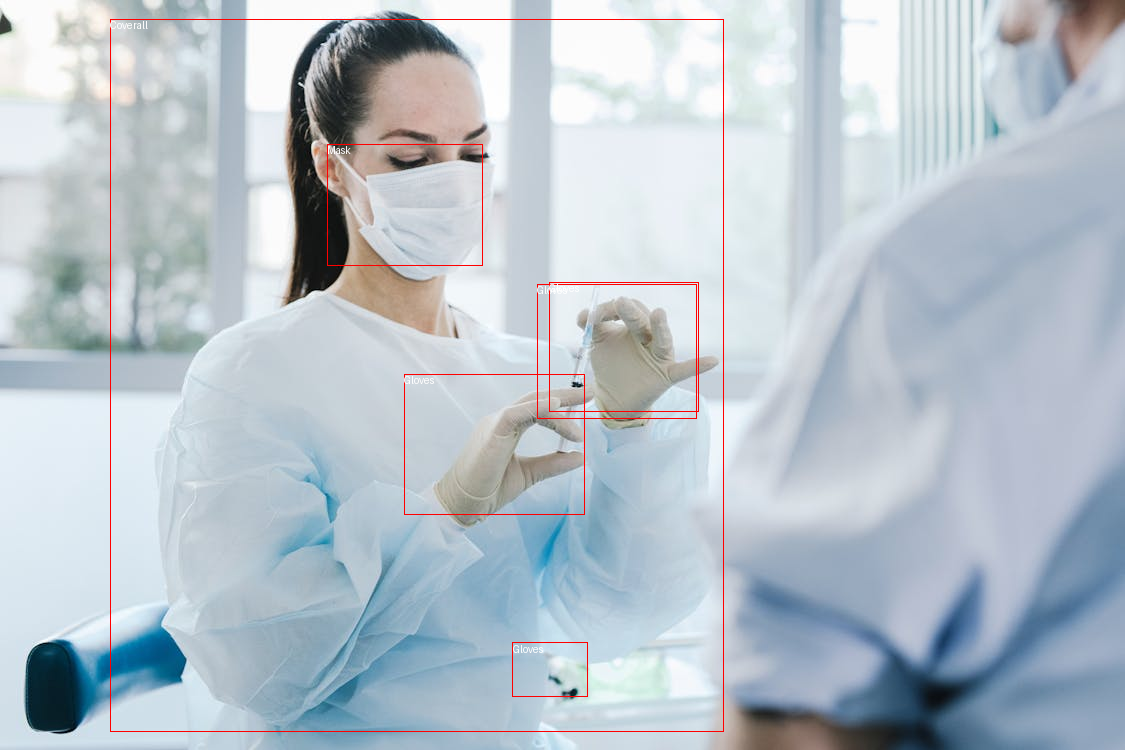

In [29]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image